# GEDI Waveform Convolutional Autoencoder #09 Test

## 1. Load Data

In [1]:
# import standard libraries
import os
import numpy as np
from pathlib import Path

# import ML libraries
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# import visualization libraries
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard

In [17]:
# get path to cwd and set project root
notebook_dir = Path.cwd()
project_root = notebook_dir.parent

# define full path to dataset and load
data_path =  os.path.join(project_root, 'data/gedi_waveforms_tf.npz')
data = np.load(data_path)

In [3]:
# Extract waveform data
waveforms = data['waveforms']

# Add new axis to waveform data
waveforms = waveforms[..., np.newaxis]

# inspect waveform data and shape
print(waveforms.shape)
print(waveforms)

(10546, 500, 1)
[[[-0.92182818]
  [-1.11135732]
  [-1.0882749 ]
  ...
  [-0.82720233]
  [-0.7545843 ]
  [-0.65852474]]

 [[-0.51685445]
  [-0.91077666]
  [-1.0163088 ]
  ...
  [-1.14346151]
  [-0.74755905]
  [-0.30184295]]

 [[-0.47643436]
  [-0.54564899]
  [-0.33103624]
  ...
  [ 0.23716828]
  [ 0.30925776]
  [ 0.10473613]]

 ...

 [[-1.01867713]
  [-1.48746914]
  [-1.54916126]
  ...
  [-0.18743011]
  [-0.19228905]
  [-0.06010556]]

 [[ 0.06117187]
  [ 0.00706989]
  [-0.20781391]
  ...
  [-0.20177718]
  [-0.17382068]
  [-0.17141481]]

 [[-0.78835739]
  [-0.72094595]
  [-0.28164888]
  ...
  [ 0.97619698]
  [ 0.64958933]
  [ 0.17167537]]]


In [4]:
# inspect metadata
meta = data['metadata']
meta

array([[2.62105003e+16, 3.37470437e+01, 1.07560844e+02, 2.19235275e+03,
        2.08168307e+03],
       [2.62105003e+16, 3.37466958e+01, 1.07561272e+02, 2.23949513e+03,
        2.09243467e+03],
       [2.62105003e+16, 3.37463476e+01, 1.07561700e+02, 2.28555638e+03,
        2.16545186e+03],
       ...,
       [2.20390800e+17, 3.36853646e+01, 1.07647559e+02, 2.37597998e+03,
        2.26107509e+03],
       [2.20390800e+17, 3.36846582e+01, 1.07648432e+02, 2.32647817e+03,
        2.21726621e+03],
       [2.20391100e+17, 3.36953802e+01, 1.07625936e+02, 2.38611265e+03,
        2.28064366e+03]])

## 2. Split Data for Training and Validation

In [5]:
x_train, x_val, meta_train, meta_val = train_test_split(
    waveforms,
    meta,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

# inspect the shape of the training and validation sets
print(f"Training data:  {x_train.shape}")
print(f"Validation data: {x_val.shape}")
print(f"Training data metadata:  {meta_train.shape}")
print(f"Validation data metadata: {meta_val.shape}")


Training data:  (7382, 500, 1)
Validation data: (3164, 500, 1)
Training data metadata:  (7382, 5)
Validation data metadata: (3164, 5)


## 3. Build and Compile Baseline CAE

In [6]:
from tensorflow.keras import layers, models, optimizers, Input

def build_CAE_09(input_shape=(500, 1)):
    """
    Build CAE_09: Best-performing convolutional autoencoder from experiment #9.

    Returns:
        autoencoder (Model): Full autoencoder model (encoder + decoder)
        encoder (Model): Encoder-only model
        decoder (Model): Decoder-only model
    """
    # Encoder
    inputs = Input(shape=input_shape, name='input_layer')
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D(2, padding='same')(x)
    x = layers.Flatten()(x)
    bottleneck = layers.Dense(8, activation='linear', name='bottleneck')(x)

    encoder = models.Model(inputs, bottleneck, name="encoder")

    # Decoder
    decoder_input = Input(shape=(8,), name='decoder_input')
    x = layers.Dense(125 * 64, activation='relu')(decoder_input)
    x = layers.Reshape((125, 64))(x)
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.UpSampling1D(2)(x)
    decoder_output = layers.Conv1D(1, 3, activation='linear', padding='same')(x)

    decoder = models.Model(decoder_input, decoder_output, name="decoder")

    # Autoencoder model
    autoencoder_output = decoder(encoder(inputs))
    autoencoder = models.Model(inputs, autoencoder_output, name="autoencoder")
    autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')

    return autoencoder, encoder, decoder

In [7]:
# Build the model
input_shape = x_train.shape[1:]
autoencoder, encoder, decoder = build_CAE_09(input_shape)

In [8]:
# Summarize models
autoencoder.summary()
encoder.summary()
decoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8)              │        70,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 500, 1)         │        90,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,969 (628.79 KB)

 Trainable params: 160,969 (628.79 KB)

 Non-trainable params: 0 (0.00 B)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 500, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 250, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 250, 64)        │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 8)              │        64,008 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,344 (274.78 KB)

 Trainable params: 70,344 (274.78 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8000)           │        72,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 125, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 125, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 250, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 500, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 500, 1)         │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,625 (354.00 KB)

 Trainable params: 90,625 (354.00 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Train CAE_09

In [9]:
import datetime

# Set TensorBoard logging directory
log_dir = project_root / "logs" / datetime.datetime.now().strftime("fit-%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, x_val),
    callbacks=[tensorboard_callback]
)

Epoch 1/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3081 - val_loss: 0.0621
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0585 - val_loss: 0.0506
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0508 - val_loss: 0.0496
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0478 - val_loss: 0.0488
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0461 - val_loss: 0.0483
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0456 - val_loss: 0.0475
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0456 - val_loss: 0.0478
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0452 - val_loss: 0.0472
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0441 - val_loss: 0.0471
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0440 - val_loss: 0.0469


We observe a large discrepancy between the validation loss and the training loss in the first epoch. Perhaps this has to do with how loss is calculated wrt batch size? Our CAE is learning very quickly.

## 4.5 Improve the model

Implement callbacks to create adaptive training process. Improve model stability and prevent overfiltting: 

- **Early Stopping**: Stops the training loop when val loss stops improving. 


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard

# Rebuild and reinitialize the model 
input_shape = x_train.shape[1:]
autoencoder, encoder, decoder = build_CAE_09(input_shape)

# Callbacks
log_dir = project_root / "logs" / datetime.datetime.now().strftime("fit-%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


# Halt training loop if val_loss doesn't improve in 5 epochs, restores best weights
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5, 
    restore_best_weights = True,
    verbose = 1
)

# Train the model 
history = autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_val, x_val),
    callbacks=[tensorboard_callback, early_stopping]
)


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3067 - val_loss: 0.0617
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0563 - val_loss: 0.0513
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0499 - val_loss: 0.0490
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0464 - val_loss: 0.0477
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0447 - val_loss: 0.0476
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0449 - val_loss: 0.0474
Epoch 8/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0442 - val_loss: 0.0477
Epoch 9/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0440 - val_loss: 0.0472
Epoch 10/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0432 - val_loss: 0.0471
Epoch 11/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0428 - val_loss: 0.0476
Epoch 12/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 

## 5. Evaluate Baseline AE on Test Set

In [11]:
test_loss = autoencoder.evaluate(x_val, x_val, verbose=1)
print(f"\nFinal reconstruction loss on validation set: {test_loss:.4f}")

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0477

Final reconstruction loss on validation set: 0.0469


## 6. Visualize Loss Curve

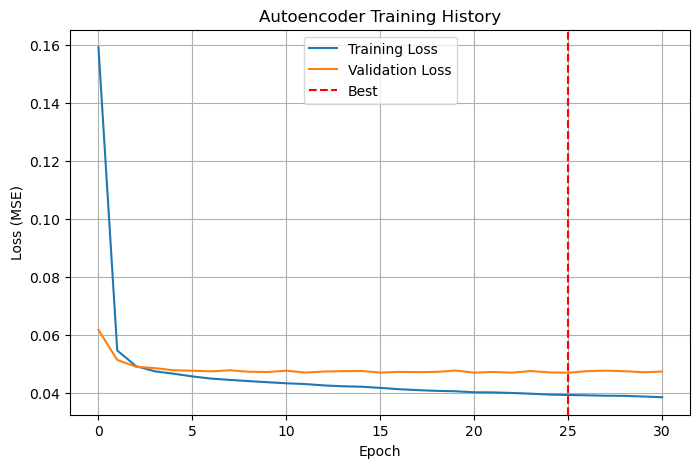

In [12]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(
    x=np.argmin(history.history['val_loss']),
    color='red', linestyle='--',
    label='Best'
)
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

## 7. Visualize OG vs. Reconstructed Waveforms

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


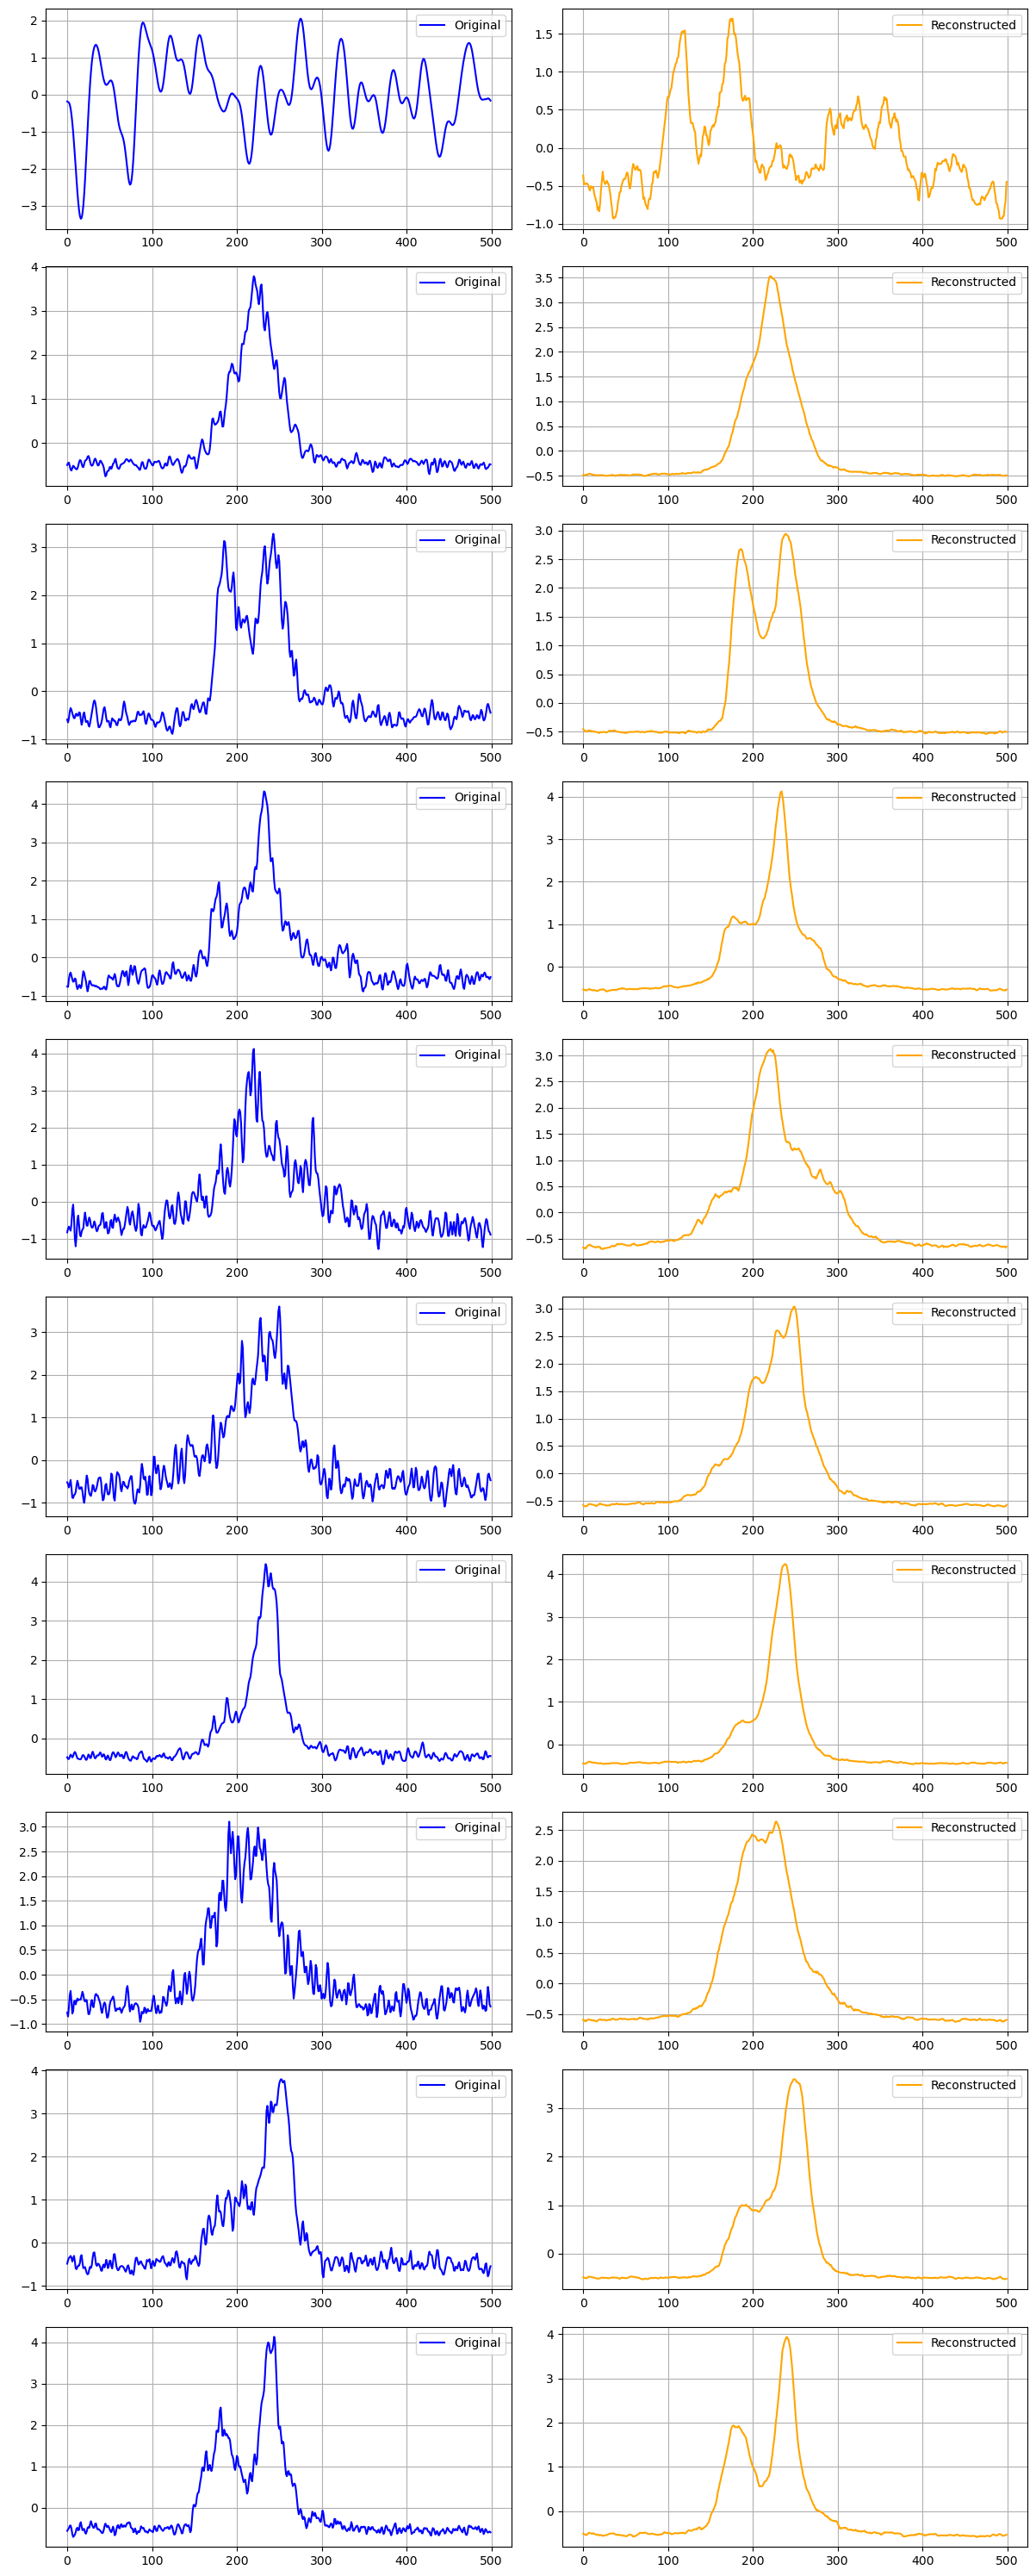

In [13]:
def plot_reconstructions(model, data, n=5):
    reconstructions = model.predict(data[:n])
    plt.figure(figsize=(12, 3 * n))
    for i in range(n):
        plt.subplot(n, 2, 2*i + 1)
        plt.plot(data[i].squeeze(), color='blue', label='Original')
        plt.legend()
        plt.grid(True)

        plt.subplot(n, 2, 2*i + 2)
        plt.plot(reconstructions[i].squeeze(), color='orange', label='Reconstructed')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Visualize reconstructions on test set
plot_reconstructions(autoencoder, x_val, n=10)

## 8. Export Model

In [16]:
# Path to models directory
model_dir = os.path.join(project_root, "models")

# Save the model and model components
autoencoder.save(os.path.join(model_dir, "cae_09_autoencoder.keras"))
encoder.save(os.path.join(model_dir, "cae_09_encoder.keras"))
decoder.save(os.path.join(model_dir, "cae_09_decoder.keras"))
